## データダウンロード

In [10]:
option = '-'
option += 'd' # delete
option += 'n' # dry-run
# ! gsutil -m rsync -r $option gs://wakimoto-ramiel/experiments/exp_20191107_kw2title/data/eccos_mecab_tfidf_top3.tgt.train ./data/eccos/
! gsutil cp gs://wakimoto-ramiel/experiments/exp_20191107_kw2title/data/eccos_mecab_tfidf_top3.tgt.train ./data/eccos/
! gsutil cp gs://wakimoto-ramiel/experiments/exp_20191107_kw2title/data/eccos_mecab_tfidf_top3.tgt.test ./data/eccos/ 
! gsutil cp gs://wakimoto-ramiel/experiments/exp_20191107_kw2title/data/eccos_mecab_tfidf_top3.tgt.valid ./data/eccos/        

Copying gs://wakimoto-ramiel/experiments/exp_20191107_kw2title/data/eccos_mecab_tfidf_top3.tgt.train...
/ [1 files][  5.7 MiB/  5.7 MiB]                                                
Operation completed over 1 objects/5.7 MiB.                                      
Copying gs://wakimoto-ramiel/experiments/exp_20191107_kw2title/data/eccos_mecab_tfidf_top3.tgt.test...
/ [1 files][  5.7 MiB/  5.7 MiB]                                                
Operation completed over 1 objects/5.7 MiB.                                      
Copying gs://wakimoto-ramiel/experiments/exp_20191107_kw2title/data/eccos_mecab_tfidf_top3.tgt.valid...
/ [1 files][ 58.7 KiB/ 58.7 KiB]                                                
Operation completed over 1 objects/58.7 KiB.                                     


## データ整形

In [5]:
def readlines(path):
    with open(path, 'r') as f:
        return [s.replace('\n', '') for s in f.readlines()]

In [154]:
readlines_by_type = lambda _type: readlines(f'./data/eccos/eccos_mecab_tfidf_top3.tgt.{_type}')
train_lines = readlines_by_type('train')
valid_lines = readlines_by_type('valid')
test_lines = readlines_by_type('test')
print(f'data loaded （train:{len(train_lines)}, valid:{len(valid_lines)}, test:{len(test_lines)}）')
# check_data_valid(train_lines, valid_lines, test_lines)

data loaded （train:48011, valid:500, test:48511）


eccosデータだとtrain, valid, testで重複あるので注意

In [155]:
def check_data_valid(train_lines, valid_lines, test_lines):
    train_set = set(train_lines)
    valid_set = set(valid_lines)
    test_set = set(test_lines)
    assert len(train_lines) == len(train_set)
    assert len(valid_lines) == len(valid_set)
    assert len(test_lines) == len(test_set)
    assert len(train_set & valid_set) == 0, f'train, valid は被ってはいけない {len(train_set & valid_set)}件重複'
    assert len(train_set & test_set) == 0, f'train, test は被ってはいけない {len(train_set & test_set)}件重複'
    assert len(valid_set & test_set) == 0, f'valid, test は被ってはいけない {len(valid_set & test_set)}件重複'

### ⛄ eccos限定処理： trainを3分割

In [156]:
from sklearn.model_selection import train_test_split
# train が全部なので
lines = readlines(f'./data/eccos/eccos_mecab_tfidf_top3.tgt.train')
train_valid_lines, test_lines = train_test_split(lines, train_size=0.8, test_size=0.2)
train_lines, valid_lines = train_test_split(train_valid_lines, train_size=0.8, test_size=0.2)
print(f'train:{len(train_lines)}, valid:{len(valid_lines)}, test:{len(test_lines)}')
check_data_valid(train_lines, valid_lines, test_lines)

train:30726, valid:7682, test:9603


In [157]:
print('\n'.join(train[100:110]))

料理 に 洗濯 、 お 掃除 ... 多忙 な ママ に オススメ の 大人気 コラーゲンサプリ ♪
微粒子 汚れ から 守り 、 色 ムラ も 自然 に カバー する エッセンス bb
自分 の 学歴 に 満足 いか ず 、 悩ん だり 自信 を 失っ て しまっ て い ませ ん か ? その 学歴コンプレックス の 解消 法 や 快く 過ごす 方法 を ご 紹介 し ます 。
どんな 時 も かわいく い たい なら 、 tpo に 合わせ た コーディネート を 。 <num> つ の シーン 別 の コーデ で 、 いろんな オシャレ を 楽しみ ましょ ♡
秋 コスメ で 大人 かわいく 決めよ う !
今や バンド t も ファッションアイテム ♡ おしゃれ な ライブ 参戦 服 を watch し ましょ う !
ぜんぶ プチプラ は 卒業 ♪ お金 を かける べき コスメ は この <num> つ ♡
ふっくら 明るい 目元 へ 導く アイクリーム
サントリー 【 オメガ エイト 】 約 <num> 日 分 増量 中 ♪ 脳 の 健康 対策 ( 機能性表示食品 )
単品 使い じゃ もったいない ! 気 に なる 「 プチプラコスメ 」 の 掛け算 レシピ


In [158]:
def save_lines(lines, path):
    with open(path, 'w') as f:
        f.write('\n'.join(lines))

In [159]:
# ! rm ./data/eccos/ptb.train.json ./data/eccos/ptb.valid.json ./data/eccos/ptb.vocab.json 

In [160]:
save_lines(train_lines, './data/eccos/ptb.train.txt')
save_lines(valid_lines, './data/eccos/ptb.valid.txt')
save_lines(test_lines, './data/eccos/ptb.test.txt')

## 文長分析

`max_sequence_length` 用

In [161]:
import pandas as pd
pd.set_option("display.max_colwidth", 500)
pd.set_option("display.max_rows", 101)
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [162]:
def plot_word_count(lines, normalize=False, label=None):
    lines = list(set(lines))
    words_list = [line.split(' ') for line in lines]
    df_line = pd.DataFrame({'line':lines, 'words':words_list})
    df_line['word_count'] = df_line.words.apply(lambda ws: len(ws))
    
    ser_word_count = df_line.groupby('word_count').count().line
    ser_word_count = ser_word_count/df_line.shape[0] if normalize else ser_word_count
    ser_word_count.plot(alpha=0.5, label=label)
    return df_line

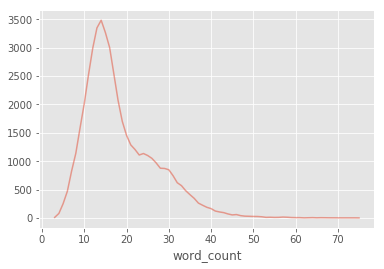

In [163]:
all_lines = train_lines + valid_lines + test_lines
df_line = plot_word_count(all_lines)
plt.savefig('./figs/eccos_word_count.png', dpi=120)

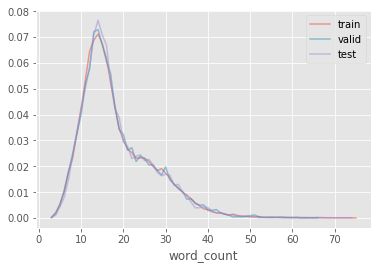

In [164]:
_ = plot_word_count(train_lines, normalize=True, label='train')
_ = plot_word_count(valid_lines, normalize=True, label='valid')
_ = plot_word_count(test_lines, normalize=True, label='test')

plt.legend()

In [165]:
exam_lines_train = readlines('./data/simple-examples/ptb.train.txt')
exam_lines_valid = readlines('./data/simple-examples/ptb.valid.txt')
exam_lines_test = readlines('./data/simple-examples/ptb.test.txt')
print(f'example train:{len(exam_lines_train)}, valid:{len(exam_lines_valid)}, test:{len(exam_lines_test)}')

example train:42068, valid:3370, test:3761


simple-examples train lines: 42068


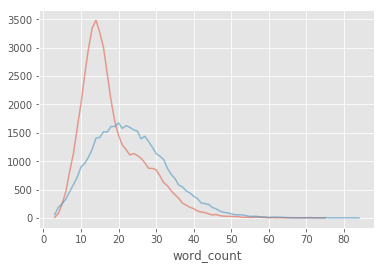

In [166]:
print(f'simple-examples train lines: {len(exam_lines)}')
_ = plot_word_count(all_lines)
_ = plot_word_count(exam_lines)

### 👀 文長ごとのコピーはどんなものかの確認

In [167]:
df_line[df_line.word_count > 40][:3]

,line,words,word_count
92,お 買い物 は 至福 の 時間 な のに 、 いつも お 財布 と 相談 し ながら しない と いけ ない 。 ショッピング 上手 に なる ため の チェックリスト を 活用 し て 、 スマート に お 買い物 を し ましょ う !,"[お, 買い物, は, 至福, の, 時間, な, のに, 、, いつも, お, 財布, と, 相談, し, ながら, しない, と, いけ, ない, 。, ショッピング, 上手, に, なる, ため, の, チェックリスト, を, 活用, し, て, 、, スマート, に, お, 買い物, を, し, ましょ, う, !]",42
99,月 に 一 度 の 待ち に 待ちわび た 、 給料日 が 今月 も やってき た ー ! 今月 の お 給料 は 、 <num> aw の 自己投資 と ゲット す べき アイテム に 使っ て み ませ ん か ?,"[月, に, 一, 度, の, 待ち, に, 待ちわび, た, 、, 給料日, が, 今月, も, やってき, た, ー, !, 今月, の, お, 給料, は, 、, <num>, aw, の, 自己投資, と, ゲット, す, べき, アイテム, に, 使っ, て, み, ませ, ん, か, ?]",41
165,「 毛穴 は 一体 どこ に ある の ?」 と 言い たく なる くらい 綺麗 な お 肌 の 秘密 は 、 ナイト ケア に ある みたい 。 <num> つ の 肌 活 で 、 誰か ら も 羨まし がら れる 素肌 を 手 に 入れ ましょ う ♡,"[「, 毛穴, は, 一体, どこ, に, ある, の, ?」, と, 言い, たく, なる, くらい, 綺麗, な, お, 肌, の, 秘密, は, 、, ナイト, ケア, に, ある, みたい, 。, <num>, つ, の, 肌, 活, で, 、, 誰か, ら, も, 羨まし, がら, れる, 素肌, を, 手, に, 入れ, ましょ, う, ♡]",49
